In this notebook, we're going to talk about how we can use performance metrics and feature importance values to identify potential cases of bias in a machine learning model.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install scikit-learn
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
import shap

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.9 MB/s eta 0:00:00


In [2]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score

# Load the dataset
diabetes_dataset = datasets.load_diabetes(as_frame=True)
df = diabetes_dataset.frame

# Rename the features for clarity
df = df.rename(columns={'s1': 'total serum cholesterol',
                        's2': 'low-density lipoproteins',
                        's3': 'high-density lipoproteins',
                        's4': 'total cholesterol',
                        's5': 'log of serum triglycerides',
                        's6': 'blood sugar'})

In [3]:
def generate_regressor(orig_df):
    """
    Train and test a regression model on the input DataFrame, returning the
    regressor, the feature names, and a dictionary of all the relevant data
    orig_df: the input DataFrame
    """
    # Set random number generator so the results are always the same
    np.random.seed(42)

    # Get the names of the features
    feature_names = df.columns.tolist()
    feature_names.remove('target')

    # Split the data into train and test sets
    train_df, test_df = train_test_split(orig_df, test_size=0.2)

    # Separate features from labels
    x_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    x_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # Create and train the model
    regr = LinearRegression()
    regr.fit(x_train, y_train)

    # Use the model to predict on the test set
    y_pred = regr.predict(x_test)

    # Create a nested dictionary of all the data for easier retrieval
    data = {'train': {'x': x_train, 'y': y_train},
            'test': {'x': x_test, 'y': y_test},
            'pred': {'x': x_test, 'y': y_pred}}
    return regr, feature_names, data

In [4]:
def generate_classifier(orig_df):
    """
    Train and test a classification model on the input DataFrame, returning the
    classifier, the feature names, and a dictionary of all the relevant data
    orig_df: the input DataFrame for regression
    """
    # Set random number generator so the results are always the same
    np.random.seed(42)

    # Copy the DataFrame since we will be modifying it
    df = orig_df.copy()

    # Get the names of the features
    feature_names = df.columns.tolist()
    feature_names.remove('target')

    # Turn the label into a binary variable
    df['target'] = df['target'] > 150

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df, test_size=0.2)

    # Separate features from labels
    x_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    x_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # Create and train the model
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)

    # Use the model to predict on the test set
    y_pred = clf.predict(x_test)

    # Create a nested dictionary of all the data for easier retrieval
    data = {'train': {'x': x_train, 'y': y_train},
            'test': {'x': x_test, 'y': y_test},
            'pred': {'x': x_test, 'y': y_pred}}
    return clf, feature_names, data

# What Is Bias?

In the context of machine learning, ***bias*** refers to the phenomenon when a machine learning model is predisposed to make unfair or skewed predictions. Bias can manifest in many forms. Some examples are described below:
* **Loan Approvals:** Machine learning algorithms used in credit scoring can exhibit bias in loan approvals. For example, people who identify as a visible minority are more likely to be turned down for loans despite having similar records and qualifications.
* **Facial Recognition Technology:** Some facial recognition algorithms produce higher error rates for women and people with darker skin tones, leading to difficulties when such individuals use technologies like Apple's Face ID.
* **Skin Cancer Detection:** Machine learning algorithms used for automated skin cancer detection have been found to exhibit bias based on skin tone. Studies have shown that these algorithms may have higher accuracy rates for lighter skin tones while performing less accurately on darker skin tones.

Although these examples primarily involve demographic variables like race and ethnicity, a model can be biased according to any and all variables. For example, a model for predicting the sale value of a home may be biased to inflate the price of homes with a pool. In the end, the features that go into models are simply a series of numbers, and models typically don't have any social context of the meaning behind these numbers.

# Where Does Bias Come From?

It is paramount that we not only reflect on the symptoms of bias but also its potential causes. There are certainly cases when data scientists intentionally create, encode, or perpetuate biases in their models. However, even engineers with the best intentions can create biased models.

To talk about some potential culprits of bias, we will discuss some examples around a problem that is discussed in a highly-cited paper by Obermeyer et al. (2019) titled ["Dissecting racial bias in an algorithm used to manage the health of populations"](https://www.science.org/doi/full/10.1126/science.aax2342).

The paper examined a widely used algorithm that helped hospitals identify high-risk patients according to a "risk score". The goal of the algorithm was to help hospitals triage patients and delvier proper care to those with complex health needs. However, Obermeyer et al. found that African-American patients who were scored according to the algorithm were typically sicker than Caucasian patients with the same risk score. This meant that there was a disproportionate number of African-American patients who were not properly identified as being high-risk.

The tables below describe some examples of how intentional and unintentional biases could have led to this bias:

**Intentional Bias**

| Category | Description |
|:----------|:-------------|
| **Discriminatory Data Collection** | A data scientist can create or manipulate data to reflect discriminatory practices or biases |
| | Example: Limiting dataset representation of African-American patients who are obviously low- and high-risk |
| **Prejudiced Feature Selection** | A data scientist can include or exclude features that are known to disproportionately impact certain kinds of inputs |
| | Example: Ignoring illnesses that are more common among African-American patients |
| **Manipulating Weights and Parameters** | A data scientist can manually manipulate the weights or rules within a machine learning model to favor specific inputs |
| | Example: Increasing the importance of illnesses that are more prevalent in Caucasian patients towards a high risk score |

**Unintentional Bias**

| Category | Description |
|:----------|:-------------|
| **Non-Representative Dataset** | A data scientist can collect / be given data that does not adequately represent the population |
| | Example: Data was collected from a clinic that only saw African-American patients who were obviously low- and high-risk |
| **Unbalanced Training** | A data scientist may split their dataset in a way that leads to biased model training |
| | Example: The training dataset only contains African-American patients who are obviously low- and high-risk, leaving all of the borderline cases in the test dataset |
| **Proxy Variables** | A data scientist may use a proxy variable to avoid using sensitive information, but that proxy may correlate with a bias |
| | Example: Postal code is used as a proxy for socio-economic status, but neighborhoods are often grouped by racial or ethnic groups |
| **Model Design** | A data scientist can pick a model architecture that happens to favor features or relationships between features that benefit a particular group |
| | Example: A simpler model might learn that a feature is statistically beneficial for overall prediction accuracy but happens to be more important to Caucasian patients |

In the case of Obermeyer et al.'s study, the authors found that the model was biased because the algorithm was trained to predict health costs as a proxy for health needs. Less money is spent on African-American patients who have the same level of need, and the algorithm thus falsely concluded that African-American patients were healthier than equally sick Caucasian patients.

Theoretically, the dataset we have used and the models we have constructed for our toy dataset do not have any intentional biases. However, we will walk through some potential strategies that can be used to see if there biases that have crept in our final products.

# Searching for Potential Bias: Biological Sex in our Regression Model

In this example, we are going to see if our regression model is biased according to patients' biological sex.

In [5]:
regr, feature_names, data = generate_regressor(df)
x_test = data['test']['x']
y_test = data['test']['y']
y_pred = data['pred']['y']

Before we do that, let's first inspect the distribution of sexes reported in our dataset:

In [6]:
df['sex'].value_counts()

sex
-0.044642    235
 0.050680    207
Name: count, dtype: int64

Remember that the dataset was normalized in advance, so instead of having something like `male = 0` or `female = 1`, the features were normalized so that they have a mean of 0 and a variance of 1.

Since this is a toy dataset, we actually don't know which feature value corresponds to male or female. We will assume that the negative values are males and the positive values are females.

## Looking at Feature Importance

Let's start off by revisiting the importance of the features in our model. While this isn't necessarily going to help us identify bias, it will give us a clue into whether the model is overweighting in the importance of biological sex. If sex is more important than all of the other features in our model (e.g., total cholesterol, blood sugar), then our domain expertise would lead us to believe that there might be something wrong.

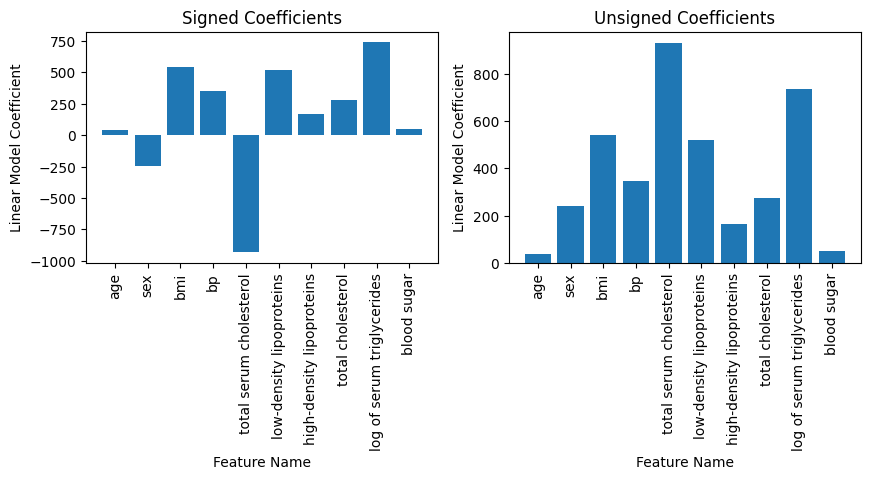

In [7]:
# Extract the coefficients of the linear model
importances = regr.coef_

# Plot the results
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(feature_names, importances)
plt.xticks(rotation = 90)
plt.title('Signed Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Linear Model Coefficient')

plt.subplot(1, 2, 2)
plt.bar(feature_names, np.abs(importances))
plt.xticks(rotation = 90)
plt.title('Unsigned Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Linear Model Coefficient')
plt.show()

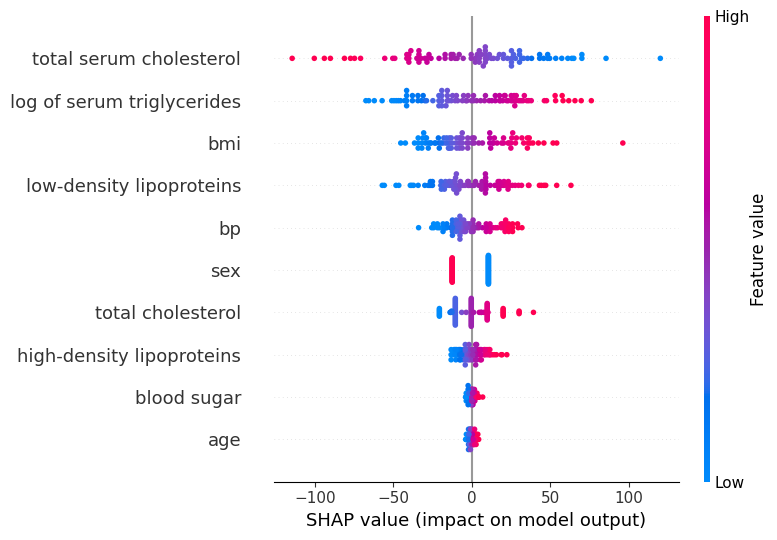

In [8]:
# Generate the SHAP explainer
explainer = shap.Explainer(regr, x_test, feature_names=feature_names)

# Apply the SHAP explainer on our test set
shap_values = explainer(x_test)

# Plot the distribution of SHAP values
shap.summary_plot(shap_values, features=x_test, feature_names=feature_names)

If we were to rank all of the features according to their importance, we would find sex in the middle of the pack — it's not the most important feature, and it's not the least important feature. Therefore, everything seems okay so far.

## Looking at Performance Metrics

To further help us identify bias with respect to a categorical variable like sex, we are going to split our test dataset into two groups: (1) the males in the test dataset and (2) the females in the test dataset.

In [9]:
# Find the rows in the test data corresponding to male and female patients
feature_idx = feature_names.index('sex')
sexes = x_test[:, feature_idx]
male_rows = sexes < 0
female_rows = sexes > 0
print(f'Number of males in the test set: {male_rows.sum():d}')
print(f'Number of females in the test set: {female_rows.sum():d}')

Number of males in the test set: 48
Number of females in the test set: 41


In [10]:
# Find all data associated with male patients in the test data
y_test_male = y_test[male_rows]
y_pred_male = y_pred[male_rows]

# Find all data associated with female patients in the test data
y_test_female = y_test[female_rows]
y_pred_female = y_pred[female_rows]

One way we can identify if there is a bias between these two groups is by examining if the model is better at predicting the outcomes in one group versus the other. We can do that by using the same performance metric we used to evaluate the overall performance of the model, but computing it separately for the males and females in the test dataset.

In this case, we are going to look at the mean absolute error (MAE) because it is directly comparable across two differently sized samples and can be easily compared to the overall range of possible disease progression scores (0 to 350).

In [11]:
mae_male = mean_absolute_error(y_test_male, y_pred_male)
mae_female = mean_absolute_error(y_test_female, y_pred_female)
print(f'MAE for males: {mae_male:0.2f}')
print(f'MAE for females: {mae_female:0.2f}')

MAE for males: 43.71
MAE for females: 41.73


We can see that there is a difference between the two models, with the MAE being is lower for females than it is for males. But is this difference is meaningful? The difference between the two groups is 2 points out of a possible 350, so it may appear small in the grand scheme of the scoring system.

Still, we are only comparing two numbers that aggregate the errors across our entire test dataset. It is important for us to determine whether this difference is due to chance or actually represents a small, but statistically meaningful bias.

We can do this by comparing two distributions of errors rather than two performance metrics.

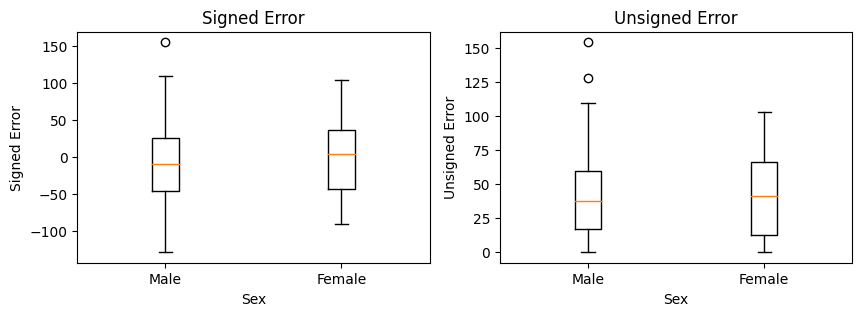

In [12]:
# Calculate the prediction error for each sample
pred_errors_males = y_pred_male - y_test_male
pred_errors_females = y_pred_female - y_test_female

# Plot the results
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.boxplot([pred_errors_males, pred_errors_females], labels=['Male', 'Female'])
plt.title('Signed Error')
plt.xlabel('Sex')
plt.ylabel('Signed Error')

plt.subplot(1, 2, 2)
plt.boxplot([np.abs(pred_errors_males), np.abs(pred_errors_females)], labels=['Male', 'Female'])
plt.title('Unsigned Error')
plt.xlabel('Sex')
plt.ylabel('Unsigned Error')
plt.show()

In [13]:
from scipy import stats
statistic, p_value = stats.ttest_ind(pred_errors_males, pred_errors_females)
print(f'Result of t-test: {statistic}, p-value is {p_value:0.3f}')

Result of t-test: -0.7122219389415237, p-value is 0.478


The statistical test confirms what we probably could have figured out from the boxplots: the observed difference in model performance across the two biological sexes is not statistically significant.

# Searching for Potential Bias: Age in our Regression Model

Let's repeat the same analysis that we did before, but with a focus on a continuous variable like age.

In [14]:
regr, feature_names, data = generate_regressor(df)
x_test = data['test']['x']
y_test = data['test']['y']
y_pred = data['pred']['y']

Let's inspect the distribution of ages reported in our dataset:

<Axes: >

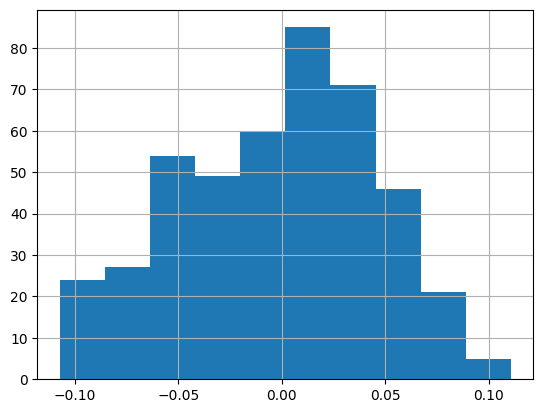

In [15]:
df['age'].hist()

Like the sex feature, the age feature in our toy dataset is normalized to have a mean of 0 and a variance of 1. Still, we can tell that the distribution is fairly normal with a slight lean towards older patients.

## Looking at Feature Importance

As before, let's examine importance of the features in our model to see if the model is overweighting in the importance of age:

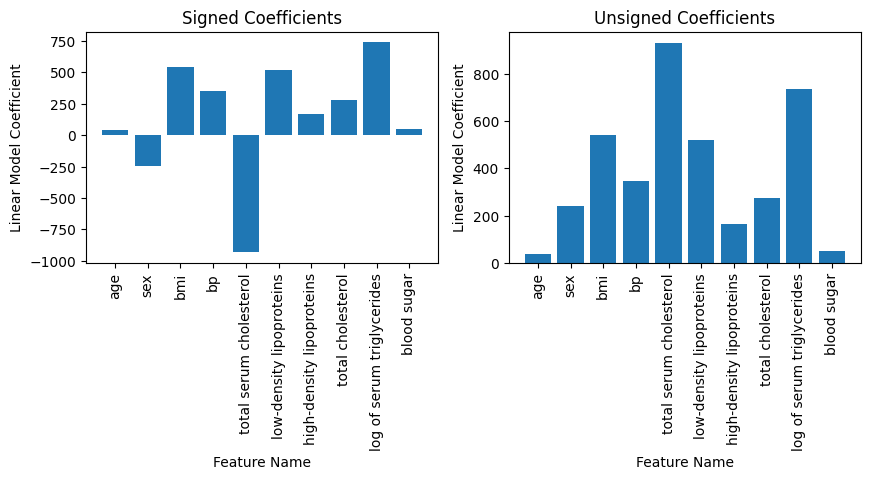

In [16]:
# Extract the coefficients of the linear model
importances = regr.coef_

# Plot the results
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.bar(feature_names, importances)
plt.xticks(rotation = 90)
plt.title('Signed Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Linear Model Coefficient')

plt.subplot(1, 2, 2)
plt.bar(feature_names, np.abs(importances))
plt.xticks(rotation = 90)
plt.title('Unsigned Coefficients')
plt.xlabel('Feature Name')
plt.ylabel('Linear Model Coefficient')
plt.show()

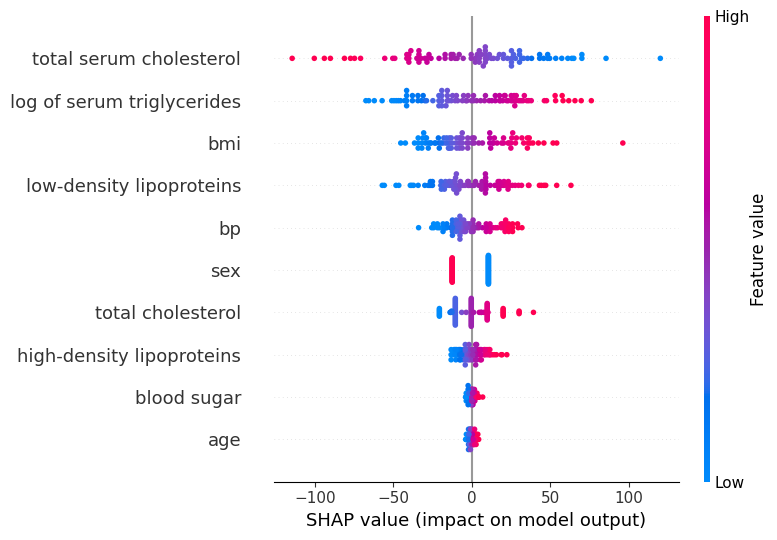

In [17]:
# Generate the SHAP explainer
explainer = shap.Explainer(regr, x_test, feature_names=feature_names)

# Apply the SHAP explainer on our test set
shap_values = explainer(x_test)

# Plot the distribution of SHAP values
shap.summary_plot(shap_values, features=x_test, feature_names=feature_names)

According to both of these analyses, it seems like age is one of the least important features in this model. Still, let's look at the performance metrics to see if there is a bias.

## Looking at Performance Metrics

Although we don't have any predefined age groups for our dataset, we could create such groups ourselves and then evaluate the classification accuracy of the model within each group individually. For simplicity, we'll make two groups: young people and older people.

In [18]:
# Find the rows in the test data corresponding to different age groups that we arbitrarily define
feature_idx = feature_names.index('age')
ages = x_test[:, feature_idx]
young_rows = ages < 0
old_rows = ages >= 0
print(f'Number of young patients the test set: {young_rows.sum():d}')
print(f'Number of old patients in the test set: {old_rows.sum():d}')

Number of young patients the test set: 48
Number of old patients in the test set: 41


In [19]:
# Find all data associated with young patients in the test data
y_test_young = y_test[young_rows]
y_pred_young = y_pred[young_rows]

# Find all data associated with old patients in the test data
y_test_old = y_test[old_rows]
y_pred_old = y_pred[old_rows]

In [20]:
mae_young = mean_absolute_error(y_test_young, y_pred_young)
mae_old = mean_absolute_error(y_test_old, y_pred_old)
print(f'MAE for young patients: {mae_young:0.2f}')
print(f'MAE for old patients: {mae_old:0.2f}')

MAE for young patients: 43.81
MAE for old patients: 41.60


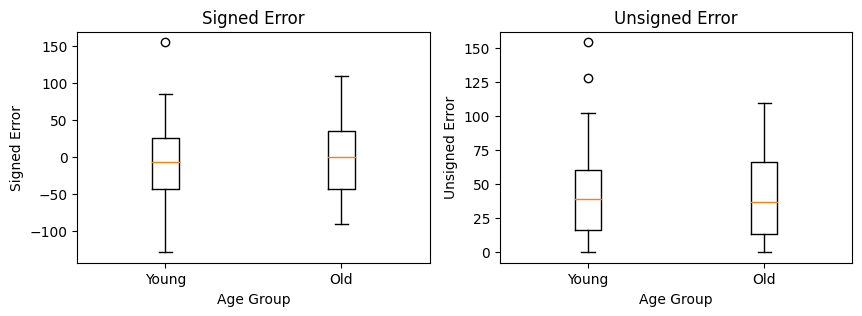

In [21]:
# Calculate the prediction error for each sample
pred_errors_young = y_pred_young - y_test_young
pred_errors_old = y_pred_old - y_test_old

# Plot the results
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.boxplot([pred_errors_young, pred_errors_old], labels=['Young', 'Old'])
plt.title('Signed Error')
plt.xlabel('Age Group')
plt.ylabel('Signed Error')

plt.subplot(1, 2, 2)
plt.boxplot([np.abs(pred_errors_young), np.abs(pred_errors_old)], labels=['Young', 'Old'])
plt.title('Unsigned Error')
plt.xlabel('Age Group')
plt.ylabel('Unsigned Error')
plt.show()

In [22]:
from scipy import stats
statistic, p_value = stats.ttest_ind(pred_errors_young, pred_errors_old)
print(f'Result of t-test: {statistic}, p-value is {p_value:0.3f}')

Result of t-test: -0.2912043877517127, p-value is 0.772


This analysis is fine, but the way that we defined the groups was somewhat arbitrary and therefore could be hiding an important trend. Instead, what we can do is calculate whether there is a correlation between age and prediction error for the individual samples in our dataset.

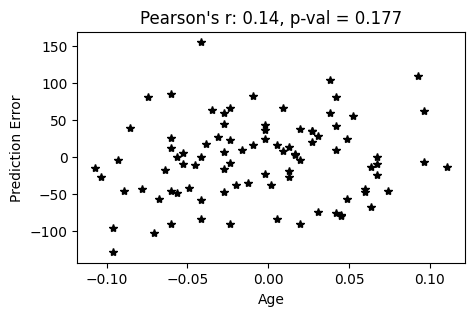

In [23]:
# Calculate the prediction error for each sample
pred_errors = y_pred - y_test

# Calculate the correlation between age and error
pearson_r, pval = stats.pearsonr(ages, pred_errors)

# Plot the results
plt.figure(figsize=(5, 3))
plt.plot(ages, pred_errors, 'k*')
plt.title(f"Pearson's r: {pearson_r:0.2f}, p-val = {pval:0.3f}")
plt.xlabel('Age')
plt.ylabel('Prediction Error')
plt.show()

If we look hard enough, we might argue that there is a slight upward trend in signed error as patient age increases; however, this trend is not statistically significant. Therefore, we might conclude that there is not a meaninful bias according to age in this model.

# Searching for Potential Bias: Sex in our Classification Model

We can do very similar analyses for a classification model, although statistical tests for establishing the significance of bias can be a bit more complicated. For simplicity, we will just examine if this model is biased according to sex.

In [24]:
clf, feature_names, data = generate_classifier(df)
x_test = data['test']['x']
y_test = data['test']['y']
y_pred = data['pred']['y']

## Looking at Feature Importance

Recall that we can assess the importance of features in a classification model using Gini importance scores:

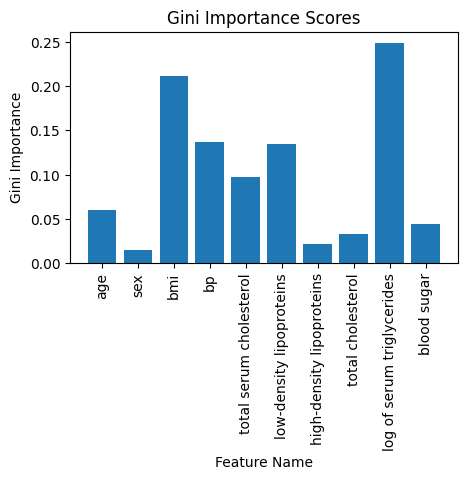

In [25]:
# Extract the Gini importance scores of the model
importances = clf.feature_importances_

# Plot the results
plt.figure(figsize=(5, 3))
plt.title('Gini Importance Scores')
plt.bar(feature_names, importances)
plt.xticks(rotation = 90)
plt.xlabel('Feature Name')
plt.ylabel('Gini Importance')
plt.show()

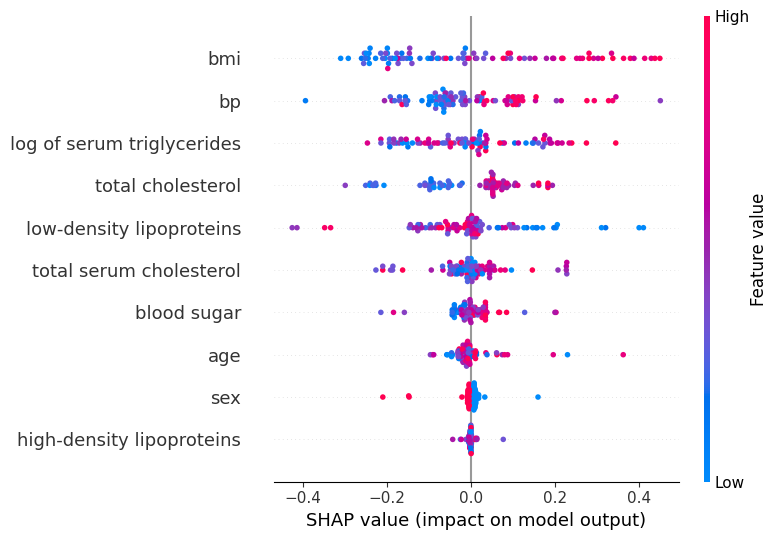

In [26]:
# Generate the SHAP explainer
explainer = shap.Explainer(clf, x_test, feature_names=feature_names)

# Apply the SHAP explainer on our test set
shap_values = explainer(x_test)

# Plot the distribution of SHAP values
target_class = 1
shap.summary_plot(shap_values[:, :, target_class], features=x_test,
                  feature_names=feature_names)

According to both of these analyses, it seems like sex is one of the least important features in this model. Still, let's look at the performance metrics to see if there is a bias.

## Looking at Performance Metrics

As before, we can compare the classifier's performance across groups using an appropriate metric. In this case, we will look at F1 score.

In [27]:
# Find the rows in the test data corresponding to male and female patients
feature_idx = feature_names.index('sex')
sexes = x_test[:, feature_idx]
male_rows = sexes < 0
female_rows = sexes > 0
print(f'Number of males in the test set: {male_rows.sum():d}')
print(f'Number of females in the test set: {female_rows.sum():d}')

Number of males in the test set: 48
Number of females in the test set: 41


In [28]:
# Find all data associated with male patients in the test data
y_test_male = y_test[male_rows]
y_pred_male = y_pred[male_rows]

# Find all data associated with female patients in the test data
y_test_female = y_test[female_rows]
y_pred_female = y_pred[female_rows]

Since we're digging into a classifer, we will quantify classification accuracy using F1 score.

In [29]:
f1_male = f1_score(y_test_male, y_pred_male)
f1_female = f1_score(y_test_female, y_pred_female)
print(f'F1 score for males: {f1_male:0.2f}')
print(f'F1 score for females: {f1_female:0.2f}')

F1 score for males: 0.44
F1 score for females: 0.72


Even though the classifier didn't seem to put much importance into biological, it seems like there is a major difference in performance between the different sexes. However, we don't know for sure if these differences are statistically meaningful. One way we could establish this is by using a statistical test called the ***Cochran-Mantel-Haenszel test*** to compare the confusion matrices between two distinct groups. This kind of analysis isn't all too common in data science, but here is one way you can do it in case you are curious:

In [30]:
!pip install statsmodels
import statsmodels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from statsmodels.stats.contingency_tables import StratifiedTable

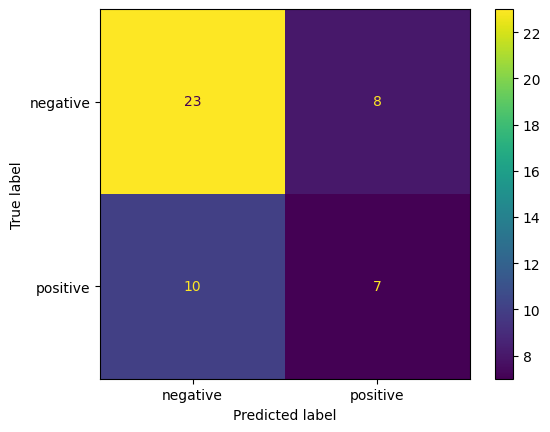

In [31]:
# Generate confusion matrices for the males
cm_male = confusion_matrix(y_test_male, y_pred_male)
classes = ['negative', 'positive']
ConfusionMatrixDisplay.from_predictions(y_test_male, y_pred_male,
                                        display_labels=classes)
plt.show()

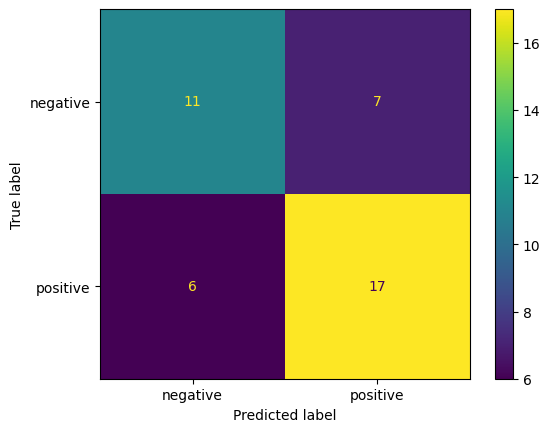

In [32]:
# Generate confusion matrices for the females
cm_female = confusion_matrix(y_test_female, y_pred_female)
classes = ['negative', 'positive']
ConfusionMatrixDisplay.from_predictions(y_test_female, y_pred_female,
                                        display_labels=classes)
plt.show()

In [33]:
# Compare the confusion matrices using the CMH test
results = StratifiedTable([cm_male, cm_female])
stat_test = results.test_equal_odds()
print(f'Result of equal odds test: {stat_test.statistic}, p-value is {stat_test.pvalue:0.3f}')

Result of equal odds test: 0.7271341032643175, p-value is 0.394


The specific test we just ran was to establish whether the confusion matrices had equal odds of making a correct decision. Since we see a high p-value, we can conclude that this test failed and that the two confusion matrices are significantly different. In other words, there seems to be a bias in model performance across the different genders! This could warrant further investation to see if the issue lies in the composition of the dataset, the features that were used, or some other factor from those listed at the top of this notebook.